In [7]:
print("Hello")
import pandas
import matplotlib.pyplot as plt


Hello


In [156]:
from pyspark.sql import SparkSession

In [159]:
spark = SparkSession.builder \
    .appName("YourAppName") \
    .master("spark://10.131.6.247:7077") \
    .getOrCreate()

In [158]:
# When we create the spark session then when the session closed all the data will be destroyed and become empty.
spark.stop()


In [160]:
df = spark.read.csv("Electric_Vehicle_Population_Data.csv", header=True, inferSchema=True)
df.show(vertical=True)

-RECORD 0-----------------------------------------------------------------
 VIN (1-10)                                        | 5YJYGDEE1L           
 County                                            | King                 
 City                                              | Seattle              
 State                                             | WA                   
 Postal Code                                       | 98122                
 Model Year                                        | 2020                 
 Make                                              | TESLA                
 Model                                             | MODEL Y              
 Electric Vehicle Type                             | Battery Electric ... 
 Clean Alternative Fuel Vehicle (CAFV) Eligibility | Clean Alternative... 
 Electric Range                                    | 291                  
 Base MSRP                                         | 0                    
 Legislative District    

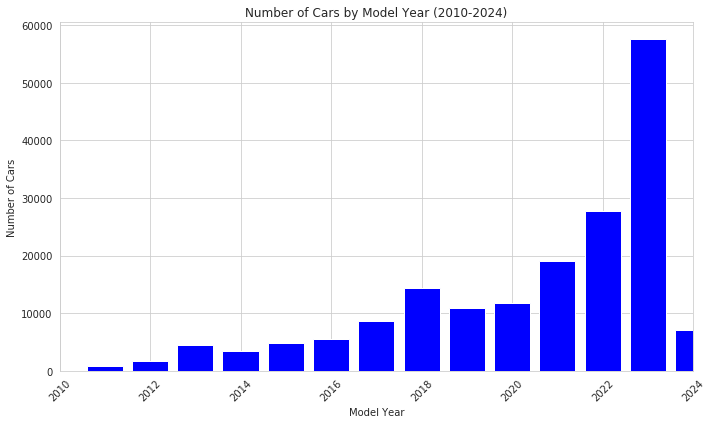

In [161]:
filtered_df = df.filter((df["Model Year"] >= 2010) & (df["Model Year"] <= 2024))

# Step 4: Group by "Model Year" and count the number of cars
car_count_by_year = filtered_df.groupBy("Model Year").count().orderBy("Model Year")

# Step 5: Convert result to Pandas DataFrame for plotting
car_count_pd = car_count_by_year.toPandas()

# Step 6: Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(car_count_pd["Model Year"], car_count_pd["count"], color='blue')
plt.xlabel('Model Year')
plt.ylabel('Number of Cars')
plt.title('Number of Cars by Model Year (2010-2024)')
plt.xticks(rotation=45)
plt.xlim(2010, 2024)  # Set the x-axis limits
plt.tight_layout()
plt.show()

In [162]:
# Step 1 & 2: Group by "Model Year" and "County", and count
from pyspark.sql.functions import col
import pandas as pd


df_grouped = df.groupBy("Model Year", "County").count()

# Step 3: Filter years from 2010 to 2024
df_filtered = df_grouped.filter((col("Model Year") >= 2010) & (col("Model Year") <= 2024))

# Step 4: Collect data for plotting
data_for_plotting = df_filtered.collect()


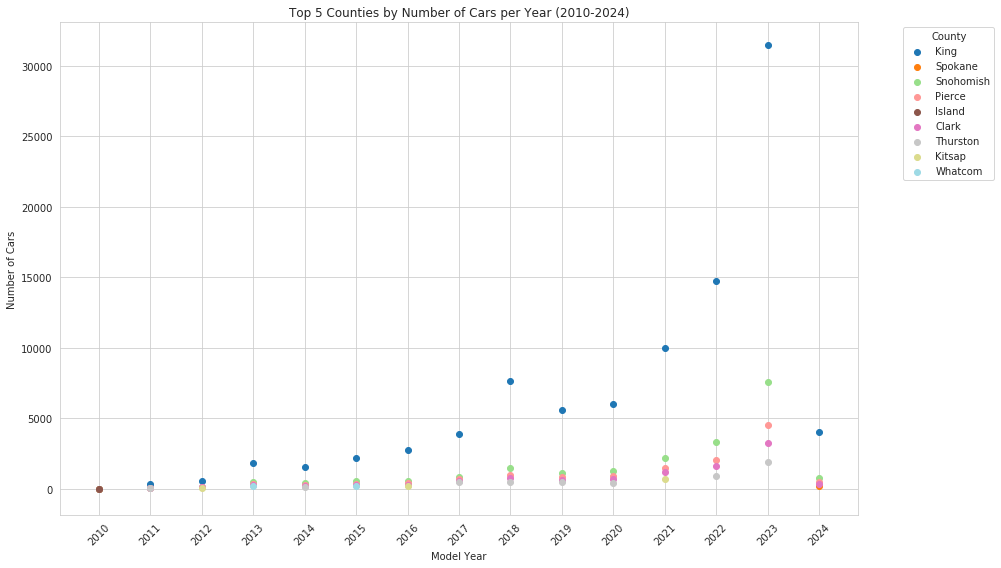

In [163]:
df_pandas = pd.DataFrame(data_for_plotting,columns=["Model Year", "County", "count"])
import numpy as np
df_pandas['Model Year'] = df_pandas['Model Year'].astype(str)
top_counties_per_year = df_pandas.groupby('Model Year').apply(
    lambda x: x.nlargest(5, 'count')
).reset_index(drop=True)

# Now 'top_counties_per_year' contains only the rows for the top 5 counties by number of cars for each year

# Step 2: Plotting
plt.figure(figsize=(14, 8))

# Since there might be fewer than 5 counties in the final years, ensuring unique colors for each
counties = top_counties_per_year['County'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(counties)))

for i, county in enumerate(counties):
    # Filter the DataFrame for each county
    df_county = top_counties_per_year[top_counties_per_year['County'] == county]
    plt.scatter(df_county['Model Year'], df_county['count'], label=county, color=colors[i])

plt.title('Top 5 Counties by Number of Cars per Year (2010-2024)')
plt.xlabel('Model Year')
plt.xticks(rotation=45)
plt.ylabel('Number of Cars')
plt.legend(title='County', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [164]:
from pyspark.sql.functions import count

car_count_by_county = df.groupBy("County").agg(count("*").alias("Number of Cars"))

# Sort the DataFrame by the count in descending order (optional, for better readability)
car_count_by_county = car_count_by_county.orderBy("Number of Cars", ascending=False)

# Show the result
car_count_by_county.show()


+------------+--------------+
|      County|Number of Cars|
+------------+--------------+
|        King|         92740|
|   Snohomish|         21001|
|      Pierce|         13782|
|       Clark|         10416|
|    Thurston|          6428|
|      Kitsap|          5840|
|     Spokane|          4586|
|     Whatcom|          4253|
|      Benton|          2147|
|      Skagit|          1910|
|      Island|          1882|
|     Clallam|          1058|
|      Chelan|          1047|
|      Yakima|           995|
|   Jefferson|           977|
|    San Juan|           942|
|     Cowlitz|           897|
|       Mason|           823|
|       Lewis|           739|
|Grays Harbor|           625|
+------------+--------------+
only showing top 20 rows



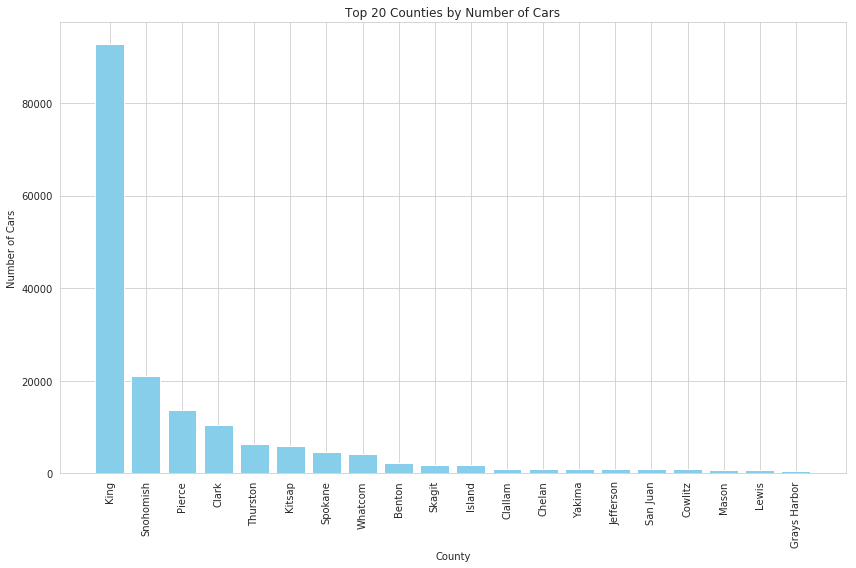

In [165]:
# Assuming 'car_count_by_county' is your Spark DataFrame after the groupBy and count operations

# Convert to Pandas DataFrame and sort
data_for_plotting = car_count_by_county.toPandas()
data_for_plotting_sorted = data_for_plotting.sort_values('Number of Cars', ascending=False).head(20)

# Now convert all county names to string type just to be sure
data_for_plotting_sorted['County'] = data_for_plotting_sorted['County'].astype(str)

# Plotting the top 20 counties
plt.figure(figsize=(12, 8))  # Adjust the size as needed
plt.bar(data_for_plotting_sorted['County'], data_for_plotting_sorted['Number of Cars'], color='skyblue')
plt.xlabel('County')
plt.xticks(rotation=90)  # Rotate the labels for better readability
plt.ylabel('Number of Cars')
plt.title('Top 20 Counties by Number of Cars')
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()


In [166]:
from pyspark.sql.functions import col, count

# Assuming your DataFrame is named 'df'
# First, find the top 5 counties based on the count of cars
top_counties = df.groupBy("County").agg(count("*").alias("Car Count")).orderBy(col("Car Count").desc()).limit(5)

# Now, join this with the original DataFrame to filter only for these top counties
df_top_counties = df.join(top_counties.select("County"), "County")

# Then, for these top counties, group by 'County' and 'Make', and count the occurrences
common_makes = df_top_counties.groupBy("County", "Make").agg(count("*").alias("Count")).orderBy("County", col("Count").desc())

# Show the results
common_makes.show()

+------+-------------+-----+
|County|         Make|Count|
+------+-------------+-----+
| Clark|        TESLA| 4310|
| Clark|    CHEVROLET|  867|
| Clark|       NISSAN|  820|
| Clark|       TOYOTA|  733|
| Clark|         FORD|  613|
| Clark|          KIA|  443|
| Clark|          BMW|  411|
| Clark|         JEEP|  324|
| Clark|      HYUNDAI|  311|
| Clark|   VOLKSWAGEN|  287|
| Clark|       RIVIAN|  197|
| Clark|        VOLVO|  186|
| Clark|         AUDI|  176|
| Clark|     CHRYSLER|  142|
| Clark|MERCEDES-BENZ|   91|
| Clark|        HONDA|   58|
| Clark|      PORSCHE|   54|
| Clark|         FIAT|   54|
| Clark|     POLESTAR|   52|
| Clark|         MINI|   49|
+------+-------------+-----+
only showing top 20 rows



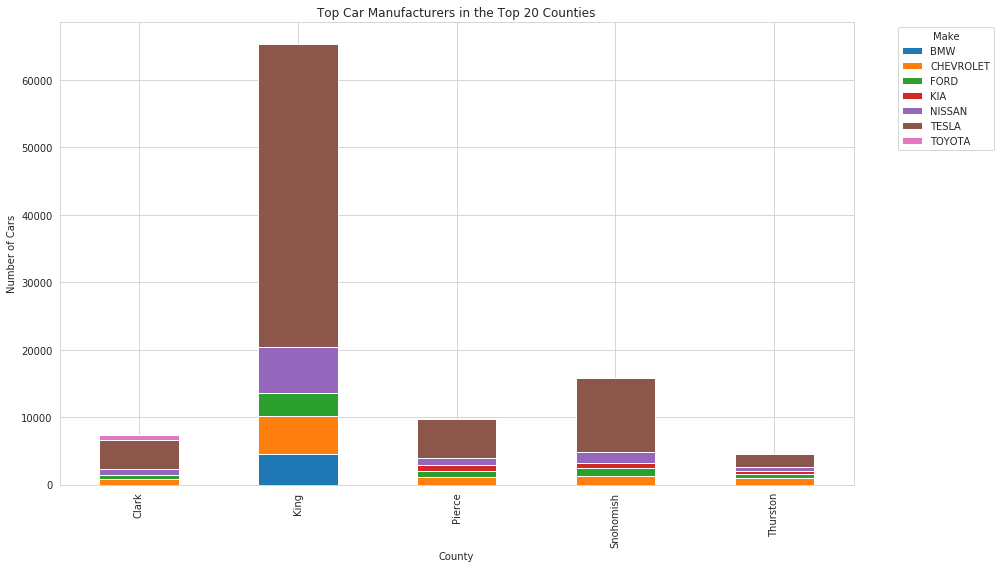

In [167]:
# Convert to Pandas DataFrame
common_makes_df = common_makes.toPandas()

# We only want the top manufacturers per county, so we'll group by 'County' and take the top N for each
N = 5  # You can set N to whatever number of top manufacturers you want per county
top_makes_per_county = common_makes_df.groupby('County').head(N).reset_index(drop=True)

# Pivot the DataFrame to get 'County' as the index, 'Make' as the columns, and 'Count' as the values
top_makes_pivot = top_makes_per_county.pivot(index='County', columns='Make', values='Count')

# Plot
top_makes_pivot.plot(kind='bar', stacked=True, figsize=(14, 8))

# Customizing the plot
plt.title('Top Car Manufacturers in the Top 20 Counties')
plt.xlabel('County')
plt.ylabel('Number of Cars')
plt.legend(title='Make', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [168]:

# Group by 'Make' and count the occurrences
make_counts = df.groupBy('Make').agg(count("*").alias('Number of Electric Vehicles'))

# Sort the counts in descending order
make_counts_sorted = make_counts.orderBy(col('Number of Electric Vehicles').desc())

# Show the manufacturer with the most electric vehicles
make_counts_sorted.show(20)

+-------------+---------------------------+
|         Make|Number of Electric Vehicles|
+-------------+---------------------------+
|        TESLA|                      79659|
|       NISSAN|                      13998|
|    CHEVROLET|                      13678|
|         FORD|                       9199|
|          BMW|                       7570|
|          KIA|                       7432|
|       TOYOTA|                       6288|
|   VOLKSWAGEN|                       5004|
|         JEEP|                       4480|
|      HYUNDAI|                       4406|
|       RIVIAN|                       4312|
|        VOLVO|                       4133|
|         AUDI|                       3646|
|     CHRYSLER|                       2993|
|MERCEDES-BENZ|                       1589|
|      PORSCHE|                       1139|
|   MITSUBISHI|                        958|
|         MINI|                        898|
|     POLESTAR|                        882|
|        HONDA|                 

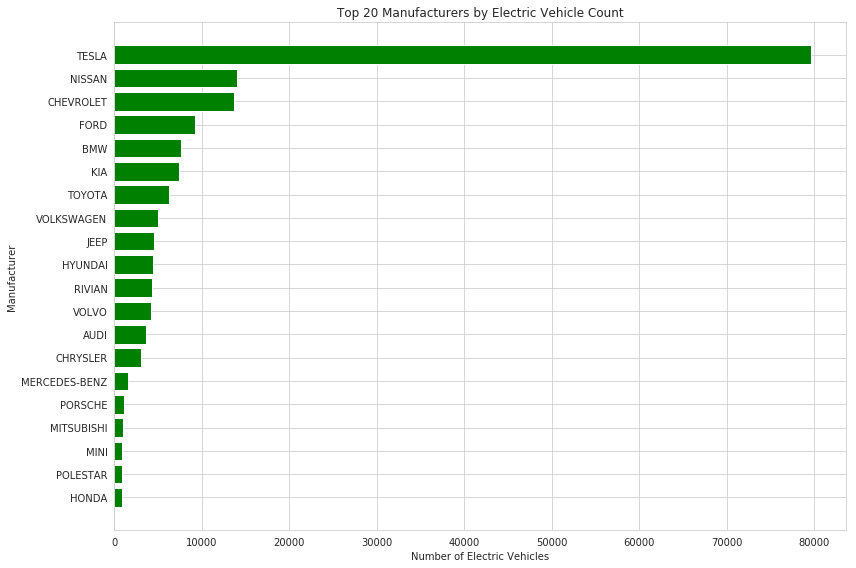

In [169]:
# Convert the Spark DataFrame to a Pandas DataFrame
make_counts_pandas = make_counts_sorted.limit(20).toPandas()

# Create a bar graph
plt.figure(figsize=(12, 8))  # Adjust the figure size as necessary
plt.barh(make_counts_pandas['Make'], make_counts_pandas['Number of Electric Vehicles'], color='green')
plt.xlabel('Number of Electric Vehicles')
plt.ylabel('Manufacturer')
plt.title('Top 20 Manufacturers by Electric Vehicle Count')
plt.gca().invert_yaxis()  # Invert the y-axis to have the manufacturer with the most EVs on top
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()


In [170]:
from pyspark.sql import Window
from pyspark.sql.functions import col, count, dense_rank

# Group by 'Make' and count the occurrences to find the most common makes
make_counts = df.groupBy("Make").agg(count("*").alias("MakeCount"))

# Define a window for ranking makes by their count
makeWindowSpec = Window.orderBy(col("MakeCount").desc())

# Apply the window specification and add a dense rank for makes
ranked_makes = make_counts.withColumn("MakeRank", dense_rank().over(makeWindowSpec))

# Filter to select the top 10 makes
top_makes = ranked_makes.filter(col("MakeRank") <= 10).select("Make")

# Now, join this with the original DataFrame to filter only for these top makes
df_top_makes = df.join(top_makes, "Make")

# Group by 'Make' and 'Model', count the occurrences, and find the most common model for each make
model_counts = df_top_makes.groupBy("Make", "Model").agg(count("*").alias("ModelCount"))

# Define a window partitioned by 'Make', ordered by 'ModelCount' descending
modelWindowSpec = Window.partitionBy("Make").orderBy(col("ModelCount").desc())

# Apply the window specification and add a row number for each 'Make' partition
model_counts_with_rank = model_counts.withColumn("ModelRank", row_number().over(modelWindowSpec))

# Filter to select only the top model for each of the top 10 makes
top_model_per_top_make = model_counts_with_rank.filter(col("ModelRank") == 1).select("Make", "Model", "ModelCount")

# Order the result by make and model count for readability
top_model_per_top_make = top_model_per_top_make.orderBy(col("ModelCount").desc())

# Show the result
top_model_per_top_make.show(10)


+----------+--------------+----------+
|      Make|         Model|ModelCount|
+----------+--------------+----------+
|     TESLA|       MODEL Y|     35989|
|    NISSAN|          LEAF|     13366|
| CHEVROLET|       BOLT EV|      6821|
|VOLKSWAGEN|          ID.4|      3937|
|      JEEP|      WRANGLER|      3392|
|      FORD|MUSTANG MACH-E|      3322|
|       KIA|          NIRO|      3150|
|    TOYOTA|   PRIUS PRIME|      2736|
|   HYUNDAI|       IONIQ 5|      2432|
|       BMW|            X5|      2412|
+----------+--------------+----------+



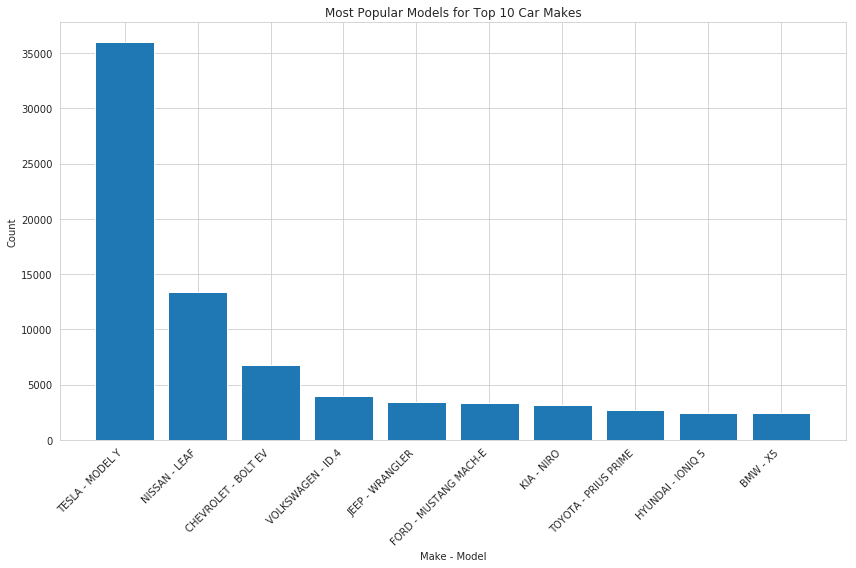

In [171]:

import matplotlib.pyplot as plt

# Ensure that you convert the Spark DataFrame to a Pandas DataFrame
top_model_per_top_make = top_model_per_top_make.toPandas()  # Uncomment if top_model_per_top_make is a Spark DataFrame

# Create a bar plot
plt.figure(figsize=(12, 8))

# Assuming 'Make' and 'Model' columns are combined into a single string for the x-axis.
# If not, you can combine them with something like:
# top_model_per_top_make['Make_Model'] = top_model_per_top_make['Make'] + " - " + top_model_per_top_make['Model']
# Then plot 'Make_Model' on the x-axis.
plt.bar(top_model_per_top_make['Make'] + ' - ' + top_model_per_top_make['Model'], top_model_per_top_make['ModelCount'])

# Add labels and title
plt.xlabel('Make - Model')
plt.xticks(rotation=45, ha='right')  # Rotate the labels for better readability
plt.ylabel('Count')
plt.title('Most Popular Models for Top 10 Car Makes')

# Display the bar plot
plt.tight_layout()  # Adjust layout to ensure everything fits without overlapping
plt.show()


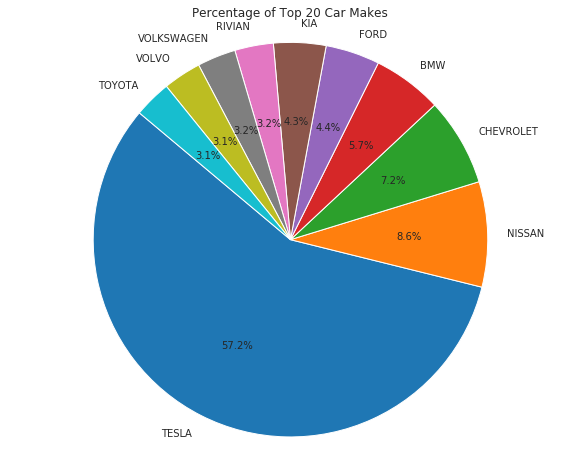

In [172]:
from pyspark.sql.functions import col, count, lit

# Example for 'King County'
county_name = "King"

# Filter for a specific county
df_county = df.filter(col('County') == county_name)

# Group by 'Make' and count the occurrences
make_counts = df_county.groupBy('Make').agg(count(lit(1)).alias('Count'))

# Convert to Pandas DataFrame
make_counts_pd = make_counts.toPandas()

# Assuming make_counts_pd is already a Pandas DataFrame with 'Make' and 'Count' columns

# Sort by 'Count' and get the top 20
make_counts_top20 = make_counts_pd.sort_values('Count', ascending=False).head(10)

# Calculate the percentage for each make in the top 20
make_counts_top20['Percentage'] = (make_counts_top20['Count'] / make_counts_top20['Count'].sum()) * 100

# Plot the pie chart for the top 20 makes
plt.figure(figsize=(10, 8))
plt.pie(make_counts_top20['Percentage'], labels=make_counts_top20['Make'], autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Top 20 Car Makes')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.show()



In [173]:
from pyspark.sql.functions import col, max

# Group by 'Make' and find the maximum 'Electric Range' for each
make_max_range = df.groupBy('Make').agg(max(col('Electric Range')).alias('Max Electric Range'))

# Sort the results by 'Max Electric Range' in descending order and get the top 20
top_make_max_range = make_max_range.orderBy(col('Max Electric Range').desc()).limit(20)

# Show the results
top_make_max_range.show()


+--------------------+------------------+
|                Make|Max Electric Range|
+--------------------+------------------+
|               TESLA|               337|
|           CHEVROLET|               259|
|             HYUNDAI|               258|
|                 KIA|               239|
|              JAGUAR|               234|
|            POLESTAR|               233|
|                AUDI|               222|
|              NISSAN|               215|
|             PORSCHE|               203|
|                 BMW|               153|
|          VOLKSWAGEN|               125|
|                MINI|               110|
|              TOYOTA|               103|
|WHEEGO ELECTRIC CARS|               100|
|                FORD|               100|
|               TH!NK|               100|
|                FIAT|                87|
|       MERCEDES-BENZ|                87|
|               SMART|                68|
|          MITSUBISHI|                62|
+--------------------+------------

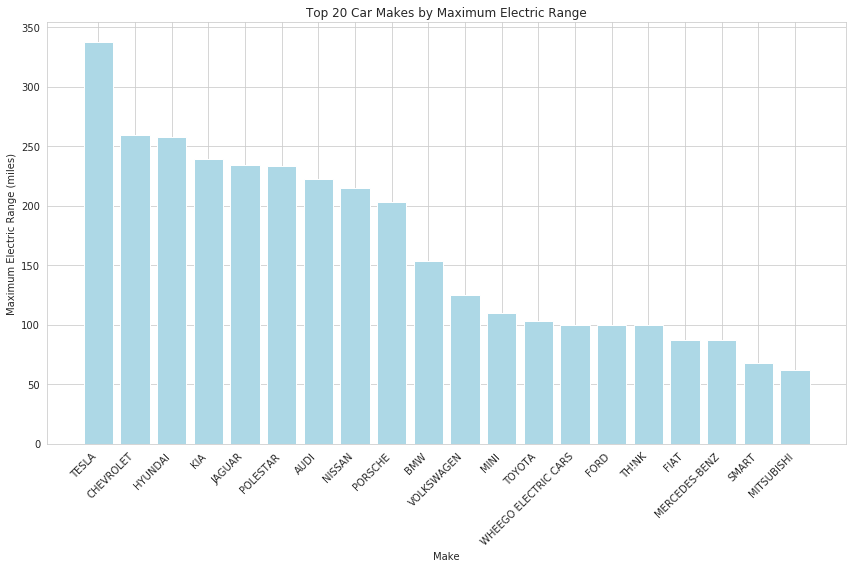

In [174]:
# Convert to Pandas DataFrame for visualization
top_make_max_range_pd = top_make_max_range.toPandas()

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.bar(top_make_max_range_pd['Make'], top_make_max_range_pd['Max Electric Range'], color='lightblue')
plt.xlabel('Make')
plt.xticks(rotation=45, ha='right')  # Rotate the labels for better readability
plt.ylabel('Maximum Electric Range (miles)')
plt.title('Top 20 Car Makes by Maximum Electric Range')
plt.tight_layout()  # Adjust layout to ensure everything fits without overlapping
plt.show()


In [175]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number

# Assuming df is your Spark DataFrame and it has 'Make', 'Model', and 'Electric Range' columns

# First, find the top 10 makes based on the maximum electric range
top_makes = df.groupBy('Make').agg(max(col('Electric Range')).alias('Max Range')) \
              .orderBy(col('Max Range').desc()).limit(10)

# Now, join the top makes with the original dataframe to filter only the rows with top makes
top_makes_df = df.join(top_makes, 'Make')

# Find the model with the maximum range for each of these makes
windowSpec = Window.partitionBy('Make').orderBy(col('Electric Range').desc())

top_models = top_makes_df.withColumn('Rank', row_number().over(windowSpec)) \
                         .filter(col('Rank') == 1).drop('Rank')

# Get the top models with their make and range
top_models = top_models.select('Make', 'Model', 'Electric Range').orderBy(col('Electric Range').desc())

# Show the results
top_models.show()


+---------+-------+--------------+
|     Make|  Model|Electric Range|
+---------+-------+--------------+
|    TESLA|MODEL S|           337|
|CHEVROLET|BOLT EV|           259|
|  HYUNDAI|   KONA|           258|
|      KIA|   NIRO|           239|
|   JAGUAR| I-PACE|           234|
| POLESTAR|    PS2|           233|
|     AUDI| E-TRON|           222|
|   NISSAN|   LEAF|           215|
|  PORSCHE| TAYCAN|           203|
|      BMW|     I3|           153|
+---------+-------+--------------+



In [177]:
import matplotlib.pyplot as plt

# Assuming top_models_pd is your Pandas DataFrame with the top model for each make
# Create a new column for Make - Model
top_models_pd['Make_Model'] = top_models_pd['Make'] + ' - ' + top_models_pd['Model']

# Sort the DataFrame based on Electric Range to display in descending order
top_models_pd = top_models_pd.sort_values('Electric Range', ascending=False)

# Create a bar chart with Make - Model on the horizontal axis
plt.figure(figsize=(14, 10))
plt.barh(top_models_pd['Make_Model'], top_models_pd['Electric Range'], color='teal')
plt.xlabel('Electric Range (miles)')
plt.ylabel('Make - Model')
plt.title('Top Electric Range Models for Each of the Top 10 Makes')
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest range at the top
plt.tight_layout()  # Adjust layout to ensure everything fits without overlapping
plt.show()


KeyError: 'Make'

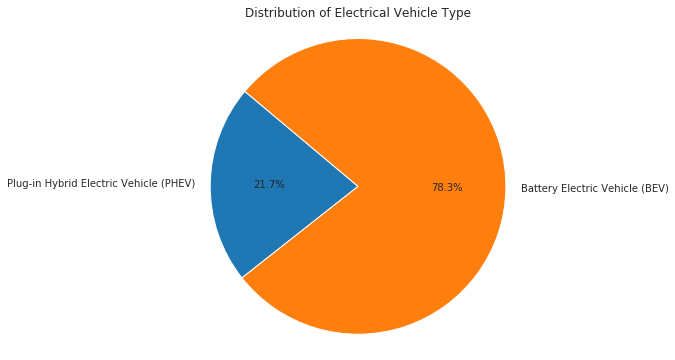

In [178]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Assuming 'df' is your Spark DataFrame
# Group by 'Electrical Vehicle Type' and count
type_counts_df = df.groupBy("Electric Vehicle Type").count()

# Convert to Pandas DataFrame for plotting
type_counts_pd = type_counts_df.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.pie(type_counts_pd['count'], labels=type_counts_pd['Electric Vehicle Type'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Distribution of Electrical Vehicle Type")
plt.show()


In [179]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Assuming 'df' is your Spark DataFrame
# Filter for only eligible vehicles
eligible_df = df.filter(col("Clean Alternative Fuel Vehicle (CAFV) Eligibility") == "Clean Alternative Fuel Vehicle Eligible")

# Group by Make and Model, and count the occurrences
eligible_make_model_df = eligible_df.groupBy("Make", "Model").count()

# Show the result
eligible_make_model_df.show()


+-------------+--------------------+-----+
|         Make|               Model|count|
+-------------+--------------------+-----+
|          KIA|            SPORTAGE|  585|
|   LAND ROVER|         RANGE ROVER|    6|
|          KIA|                SOUL|  401|
|     POLESTAR|                 PS2|  143|
|    CHEVROLET|         S-10 PICKUP|    1|
|      HYUNDAI|              TUCSON|  195|
|        VOLVO|                XC60|  464|
|MERCEDES-BENZ|             B-CLASS|   90|
|       TOYOTA|               PRIUS|   90|
|   LAND ROVER|   RANGE ROVER SPORT|    3|
|   MITSUBISHI|           OUTLANDER|  356|
|        VOLVO|                 S60|   63|
|          BMW|                  X5| 1901|
|         MINI|             HARDTOP|  120|
|    CHEVROLET|             BOLT EV| 4320|
|        SMART|FORTWO ELECTRIC D...|  151|
|        SMART|           EQ FORTWO|   54|
|        LEXUS|                  NX|  188|
|         FORD|              ESCAPE|  392|
|          KIA|             SORENTO|  618|
+----------

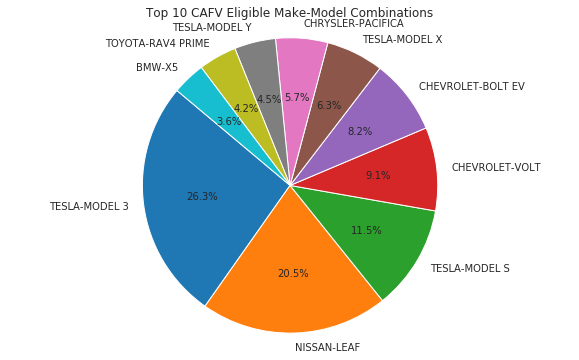

In [180]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat_ws
import matplotlib.pyplot as plt

# Filter for CAFV Eligible
eligible_df = df.filter(col("Clean Alternative Fuel Vehicle (CAFV) Eligibility") == "Clean Alternative Fuel Vehicle Eligible")

# Create a 'Make-Model' combination column
eligible_df = eligible_df.withColumn("Make-Model", concat_ws("-", col("Make"), col("Model")))

# Group by 'Make-Model' and count, then order by count descending
top_make_model_df = eligible_df.groupBy("Make-Model").count().orderBy(col("count").desc()).limit(10)

# Convert to Pandas DataFrame for plotting
top_make_model_pd = top_make_model_df.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.pie(top_make_model_pd['count'], labels=top_make_model_pd['Make-Model'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle
plt.title("Top 10 CAFV Eligible Make-Model Combinations")
plt.show()


In [181]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract, col

# Assuming 'df' is your Spark DataFrame
# Define the regular expression pattern for coordinates
coord_pattern = r'POINT \(([^ ]+) ([^ ]+)\)'

# Add columns for longitude and latitude by extracting from the 'Vehicle Location' column
df_with_coords = df.withColumn('Longitude', regexp_extract('Vehicle Location', coord_pattern, 1).cast('float')) \
                   .withColumn('Latitude', regexp_extract('Vehicle Location', coord_pattern, 2).cast('float'))

# Group by 'Longitude' and 'Latitude', count, and order by count descending
top_locations_df = df_with_coords.groupBy('Longitude', 'Latitude').count().orderBy(col("count").desc()).limit(10)

# Show the result
top_locations_df.show()


+-----------+---------+-----+
|  Longitude| Latitude|count|
+-----------+---------+-----+
| -122.12302| 47.67668| 4574|
|  -122.1873|47.820244| 3329|
| -122.20264|  47.6785| 3051|
| -122.29179| 47.43473| 2911|
| -122.16937|47.571014| 2837|
|-122.201904| 47.61385| 2823|
|  -122.3185| 47.67949| 2717|
| -122.03133| 47.62858| 2527|
|-122.151665| 47.75855| 2437|
| -122.20928| 47.71124| 2364|
+-----------+---------+-----+



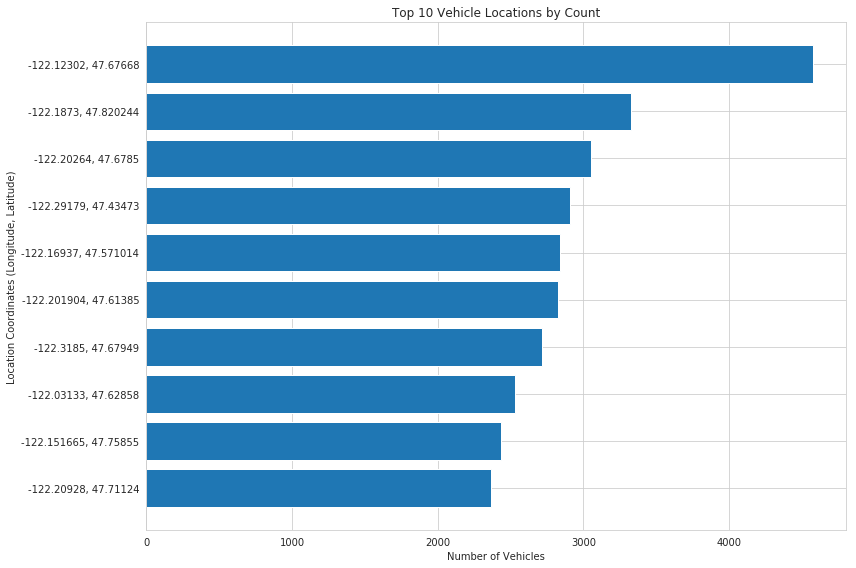

In [182]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract, col
import matplotlib.pyplot as plt

# Assuming 'df' is your Spark DataFrame
# Extract longitude and latitude from the 'Vehicle Location' column
coord_pattern = r'POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)'
df_with_coords = df.withColumn('Longitude', regexp_extract('Vehicle Location', coord_pattern, 1).cast('float')) \
                   .withColumn('Latitude', regexp_extract('Vehicle Location', coord_pattern, 2).cast('float'))

# Group by 'Longitude' and 'Latitude', count, and order by count descending
top_locations_df = df_with_coords.groupBy('Longitude', 'Latitude').count().orderBy(col("count").desc()).limit(10)

# Convert to Pandas DataFrame for easier plotting
top_locations_pd = top_locations_df.toPandas()

# Plotting
plt.figure(figsize=(12, 8))
top_locations_pd.sort_values(by='count', ascending=True, inplace=True)
plt.barh(top_locations_pd['Longitude'].astype(str) + ', ' + top_locations_pd['Latitude'].astype(str), top_locations_pd['count'])
plt.xlabel('Number of Vehicles')
plt.ylabel('Location Coordinates (Longitude, Latitude)')
plt.title('Top 10 Vehicle Locations by Count')
plt.tight_layout()
plt.show()


In [183]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Assuming the SparkSession is already initialized as `spark`

# Read the CSV file into a Spark DataFrame
df = spark.read.csv("Electric_Vehicle_Population_Data.csv", header=True, inferSchema=True)

# Filter for model years from 2010 to 2024
filtered_df = df.filter((F.col("Model Year") >= 2010) & (F.col("Model Year") <= 2024))

# Group by "Make" and "Model Year" and count the occurrences
grouped_df = filtered_df.groupBy("Make", "Model Year").count()

# Define a window partitioned by "Model Year" and ordered by count in descending order
windowSpec = Window.partitionBy("Model Year").orderBy(F.desc("count"))

# Rank the makes within each model year based on their count
ranked_df = grouped_df.withColumn("rank", F.rank().over(windowSpec))

# Filter to get only the top make (highest count) for each model year
top_makes_df = ranked_df.filter(ranked_df.rank == 1).orderBy("Model Year", F.desc("count"))

# Show the results
top_makes_df.show()


+---------+----------+-----+----+
|     Make|Model Year|count|rank|
+---------+----------+-----+----+
|    TESLA|      2010|   20|   1|
|   NISSAN|      2011|  682|   1|
|   NISSAN|      2012|  564|   1|
|   NISSAN|      2013| 1892|   1|
|CHEVROLET|      2014|  712|   1|
|   NISSAN|      2015| 1783|   1|
|    TESLA|      2016| 1578|   1|
|CHEVROLET|      2017| 2827|   1|
|    TESLA|      2018| 7915|   1|
|    TESLA|      2019| 4725|   1|
|    TESLA|      2020| 7094|   1|
|    TESLA|      2021|11118|   1|
|    TESLA|      2022|13751|   1|
|    TESLA|      2023|28650|   1|
|      BMW|      2024| 1176|   1|
+---------+----------+-----+----+



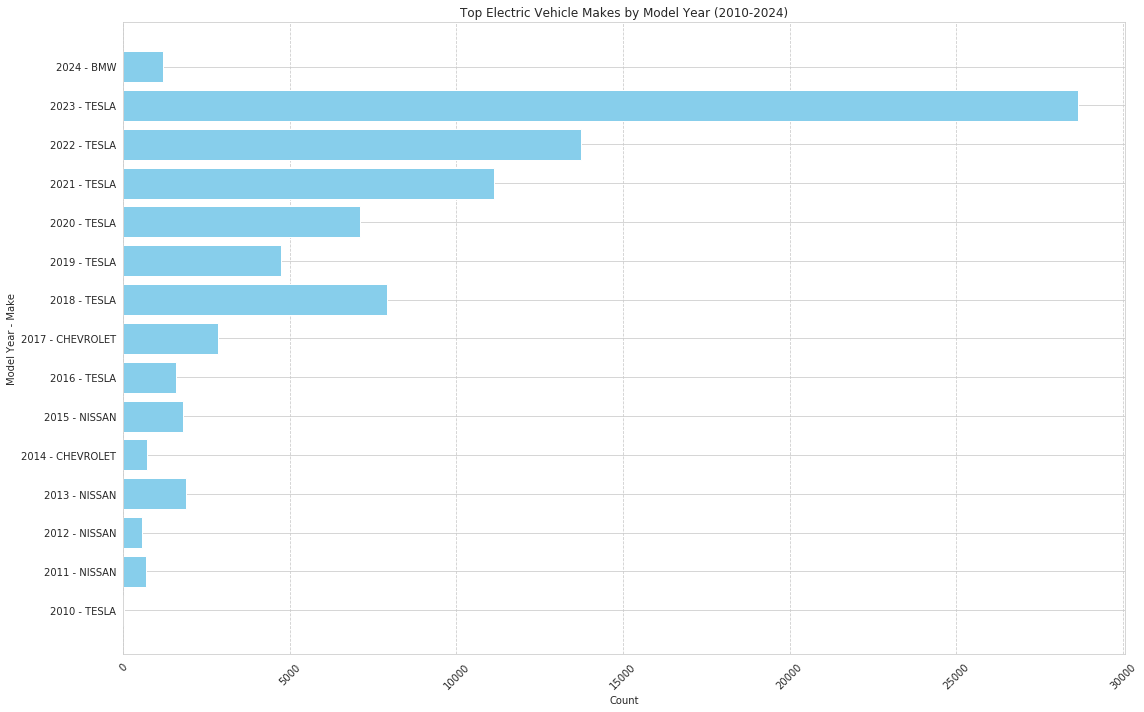

In [184]:
# Convert to Pandas DataFrame for plotting
pandas_df = top_makes_df.toPandas()
# Create a new column 'Year_Make' by concatenating 'Model Year' and 'Make' with a separator
pandas_df['Year_Make'] = pandas_df['Model Year'].astype(str) + " - " + pandas_df['Make']

# Plotting
plt.figure(figsize=(16, 10))
plt.barh(pandas_df['Year_Make'], pandas_df['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Model Year - Make')
plt.title('Top Electric Vehicle Makes by Model Year (2010-2024)')
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--')

# Show plot
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

In [185]:
# Calculate the average electric range for BEVs
avg_bev_range = df.filter(df["Electric Vehicle Type"] == "Battery Electric Vehicle (BEV)") \
                  .agg(F.avg("Electric Range").alias("Average Range BEV"))

# Calculate the average electric range for PHEVs
avg_phev_range = df.filter(df["Electric Vehicle Type"] == "Plug-in Hybrid Electric Vehicle (PHEV)") \
                   .agg(F.avg("Electric Range").alias("Average Range PHEV"))

# Show the results
avg_bev_range.show()
avg_phev_range.show()

+-----------------+
|Average Range BEV|
+-----------------+
|66.62731843976727|
+-----------------+

+------------------+
|Average Range PHEV|
+------------------+
| 30.80585161423841|
+------------------+



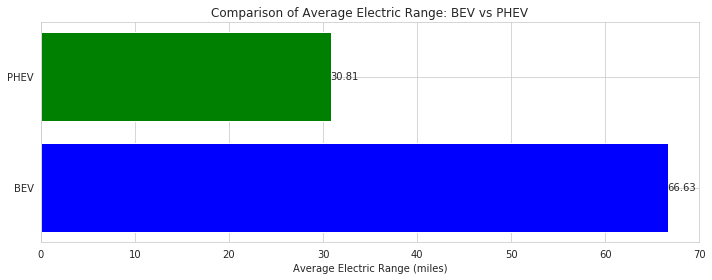

In [186]:
import matplotlib.pyplot as plt

# Average ranges for BEV and PHEV from your results
average_range_bev = 66.63  # Rounded from your result
average_range_phev = 30.81  # Rounded from your result

# Vehicle types and corresponding average ranges
vehicle_types = ['BEV', 'PHEV']
average_ranges = [average_range_bev, average_range_phev]

# Plotting a horizontal bar chart
plt.figure(figsize=(10, 4))
bars = plt.barh(vehicle_types, average_ranges, color=['blue', 'green'])

# Adding the data labels next to the bars
for bar in bars:
    plt.text(
        bar.get_width(),       # Get the end point of the bar
        bar.get_y() + bar.get_height() / 2,  # Y position at the center of the bar
        f'{bar.get_width():.2f}',  # The label
        va='center'  # Center alignment
    )

# Adding labels and title
plt.xlabel('Average Electric Range (miles)')
plt.title('Comparison of Average Electric Range: BEV vs PHEV')

# Display the plot
plt.tight_layout()
plt.show()


In [187]:
from pyspark.sql import functions as F

# Read the CSV file into a Spark DataFrame
df = spark.read.csv("Electric_Vehicle_Population_Data.csv", header=True, inferSchema=True)

# Filter the DataFrame for the years 2010 to 2023
df_filtered = df.filter((F.col("Model Year") >= 2010) & (F.col("Model Year") <= 2023))

# Group by 'Model Year' and count the occurrences
yearly_counts = df_filtered.groupBy('Model Year').agg(F.count("*").alias('Number of Electric Vehicles'))

# Sort the counts in ascending order of 'Model Year'
yearly_counts_sorted = yearly_counts.orderBy('Model Year')

# Show the results
yearly_counts_sorted.show()


+----------+---------------------------+
|Model Year|Number of Electric Vehicles|
+----------+---------------------------+
|      2010|                         23|
|      2011|                        775|
|      2012|                       1618|
|      2013|                       4409|
|      2014|                       3509|
|      2015|                       4844|
|      2016|                       5483|
|      2017|                       8562|
|      2018|                      14323|
|      2019|                      10940|
|      2020|                      11768|
|      2021|                      19132|
|      2022|                      27776|
|      2023|                      57587|
+----------+---------------------------+



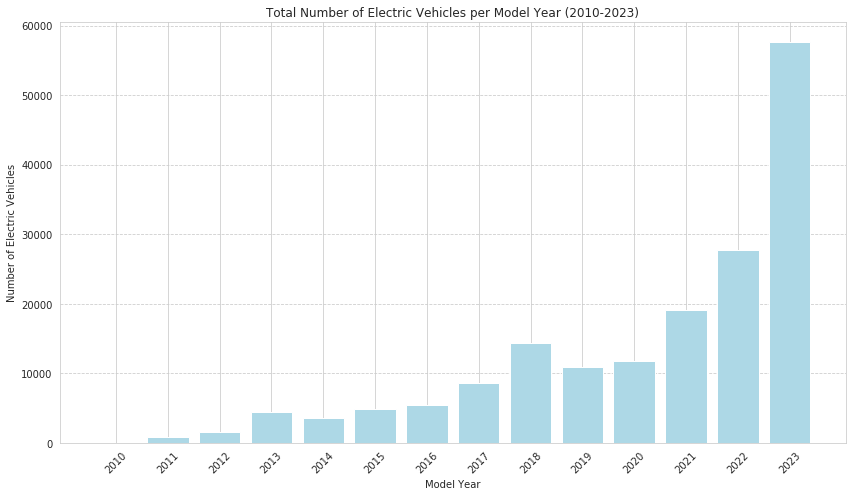

In [188]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the Spark DataFrame to a Pandas DataFrame
yearly_counts_pandas = yearly_counts_sorted.toPandas()

# Plotting
plt.figure(figsize=(12, 7))
plt.bar(yearly_counts_pandas['Model Year'].astype(str), yearly_counts_pandas['Number of Electric Vehicles'], color='lightblue')
plt.xlabel('Model Year')
plt.ylabel('Number of Electric Vehicles')
plt.title('Total Number of Electric Vehicles per Model Year (2010-2023)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.tight_layout()  # Adjust the layout
plt.show()


In [189]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

# Load the data
df = spark.read.csv("Electric_Vehicle_Population_Data.csv", header=True, inferSchema=True)

# Group by 'Model Year' and count the number of vehicles
df_grouped = df.groupBy("Model Year").agg(count("*").alias("Number of Electric Vehicles"))

# Prepare the data for machine learning
vectorAssembler = VectorAssembler(inputCols=["Model Year"], outputCol="features")
df_vect = vectorAssembler.transform(df_grouped).select("features", "Number of Electric Vehicles")

# Train the linear regression model
lr = LinearRegression(featuresCol="features", labelCol="Number of Electric Vehicles")
lr_model = lr.fit(df_vect)

# Make a DataFrame for the years 2024 to 2030
future_years_df = spark.createDataFrame([(year,) for year in range(2024, 2031)], ["Model Year"])
future_years_vect = vectorAssembler.transform(future_years_df)

# Make predictions for 2024 to 2030
predictions = lr_model.transform(future_years_vect)

# Cast the prediction to an integer
predictions = predictions.withColumn("prediction", col("prediction").cast(IntegerType()))

# Show the predictions with integer values
predictions.select("Model Year", "prediction").show()

+----------+----------+
|Model Year|prediction|
+----------+----------+
|      2024|     19756|
|      2025|     20721|
|      2026|     21686|
|      2027|     22652|
|      2028|     23617|
|      2029|     24582|
|      2030|     25547|
+----------+----------+



In [190]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import count

# Assuming your DataFrame 'df' is already loaded and prepared

# Group by 'Model Year' and count the number of vehicles
df_grouped = df.groupBy("Model Year").agg(count("*").alias("Number of Electric Vehicles"))

# Prepare the data for machine learning
vectorAssembler = VectorAssembler(inputCols=["Model Year"], outputCol="features")
df_vect = vectorAssembler.transform(df_grouped).select("features", "Number of Electric Vehicles")

# Initialize the Random Forest regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="Number of Electric Vehicles")

# Create a parameter grid for tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# Define the evaluator
evaluator = RegressionEvaluator(labelCol="Number of Electric Vehicles", predictionCol="prediction", metricName="rmse")

# Set up cross-validation
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Fit the model
cvModel = crossval.fit(df_vect)

# Now, cvModel is defined and can be used for predictions.


In [191]:
# Prepare the DataFrame for future years 2024 to 2030
future_years_list = [(year,) for year in range(2024, 2031)]
future_years_df = spark.createDataFrame(future_years_list, ["Model Year"])

# Since the model expects a features column, we'll transform the future years DataFrame using the VectorAssembler
# Note: This assumes vectorAssembler was defined in your workspace as shown in previous steps
future_years_df = vectorAssembler.transform(future_years_df)

# Make predictions for 2024 to 2030 using the trained model
predictions = cvModel.transform(future_years_df)

# Cast the prediction to an integer for a cleaner presentation
predictions = predictions.withColumn("prediction", col("prediction").cast(IntegerType()))

# Show the predictions
# Adjusting the display to include the year from the features column if necessary
predictions.select("features", "prediction").show()


+--------+----------+
|features|prediction|
+--------+----------+
|[2024.0]|     22213|
|[2025.0]|     22213|
|[2026.0]|     22213|
|[2027.0]|     22213|
|[2028.0]|     22213|
|[2029.0]|     22213|
|[2030.0]|     22213|
+--------+----------+



In [192]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Applying a logarithmic transformation to the electric vehicle counts
log_ev_counts = np.log(yearly_counts_sorted.toPandas())
print(log_ev_counts)
# Creating the model for the transformed data
log_model = LinearRegression()

# Fitting the model to the years and the logarithmically transformed EV counts
log_model.fit(years, log_ev_counts)

# Predicting the logarithm of the EV counts for 2024 to 2030
log_predicted_ev_counts = log_model.predict(predict_years)

# Inversely transforming the predictions to get the actual EV counts
predicted_ev_counts_exponential = np.exp(log_predicted_ev_counts)

predicted_ev_counts_exponential


    Model Year  Number of Electric Vehicles
0     7.605890                     3.135494
1     7.606387                     6.652863
2     7.606885                     7.388946
3     7.607381                     8.391403
4     7.607878                     8.163086
5     7.608374                     8.485496
6     7.608871                     8.609408
7     7.609367                     9.055089
8     7.609862                     9.569622
9     7.610358                     9.300181
10    7.610853                     9.373139
11    7.611348                     9.859118
12    7.611842                    10.231928
13    7.612337                    10.961052


NameError: name 'predict_years' is not defined

In [143]:
from pyspark.sql import functions as F

# Read the CSV file into a Spark DataFrame
# df = spark.read.csv("Electric_Vehicle_Population_Data.csv", header=True, inferSchema=True)

# Filter the DataFrame for the years 2010 to 2023
df_filtered = df.filter((F.col("Model Year") >= 2010) & (F.col("Model Year") <= 2023))

# Group by 'Model Year' and count the occurrences
yearly_counts = df_filtered.groupBy('Model Year').agg(F.count("*").alias('Number of Electric Vehicles'))

# Sort the counts in ascending order of 'Model Year'
yearly_counts_sorted = yearly_counts.orderBy('Model Year')
print(type(yearly_counts_sorted))
# Show the results
yearly_counts_sorted.show()


<class 'pyspark.sql.dataframe.DataFrame'>
+----------+---------------------------+
|Model Year|Number of Electric Vehicles|
+----------+---------------------------+
|      2010|                         23|
|      2011|                        775|
|      2012|                       1618|
|      2013|                       4409|
|      2014|                       3509|
|      2015|                       4844|
|      2016|                       5483|
|      2017|                       8562|
|      2018|                      14323|
|      2019|                      10940|
|      2020|                      11768|
|      2021|                      19132|
|      2022|                      27776|
|      2023|                      57587|
+----------+---------------------------+



In [144]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Prepare the data
pandas_df = yearly_counts_sorted.toPandas()
years = pandas_df['Model Year'].values.reshape(-1, 1)
ev_counts = pandas_df['Number of Electric Vehicles'].values

# Transform counts for exponential model
log_ev_counts = np.log(ev_counts)

# Create and fit the model
model = LinearRegression()
model.fit(years, log_ev_counts)

# Predict for future years
future_years = np.arange(2024, 2031).reshape(-1, 1)
log_predicted_counts = model.predict(future_years)
predicted_counts = np.exp(log_predicted_counts)

# Print the predicted counts
for year, count in zip(future_years.flatten(), predicted_counts):
    print(f"Year {year}: Estimated EV count = {int(count)}")


Year 2024: Estimated EV count = 96075
Year 2025: Estimated EV count = 142570
Year 2026: Estimated EV count = 211566
Year 2027: Estimated EV count = 313952
Year 2028: Estimated EV count = 465886
Year 2029: Estimated EV count = 691348
Year 2030: Estimated EV count = 1025920


In [150]:
# Doing the same Analysis as above.

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
# Assuming yearly_counts_sorted is your Spark DataFrame containing columns 'Model Year' and 'Number of Electric Vehicles'

# Prepare the data
assembler = VectorAssembler(inputCols=["Model Year"], outputCol="features")
df = assembler.transform(yearly_counts_sorted)

# Transform counts for exponential model
df = df.withColumn("log_ev_counts", F.log("Number of Electric Vehicles"))

# Create and fit the model
lr = LinearRegression(featuresCol="features", labelCol="log_ev_counts")
model = lr.fit(df)

# Predict for future years
future_years_df = spark.range(2024, 2031, step=1).toDF("Model Year")
future_years_df = assembler.transform(future_years_df)
predictions = model.transform(future_years_df)

# Exponential transformation to get predicted counts
predicted_counts = predictions.select("Model Year", F.exp("prediction").alias("predicted_counts"))

# Show the predicted counts
predicted_counts.show()



+----------+------------------+
|Model Year|  predicted_counts|
+----------+------------------+
|      2024| 96075.70816849484|
|      2025|142570.70153120594|
|      2026|211566.53770849484|
|      2027|313952.30154045916|
|      2028|465886.75463583844|
|      2029| 691348.5490634078|
|      2030|1025920.5945137462|
+----------+------------------+



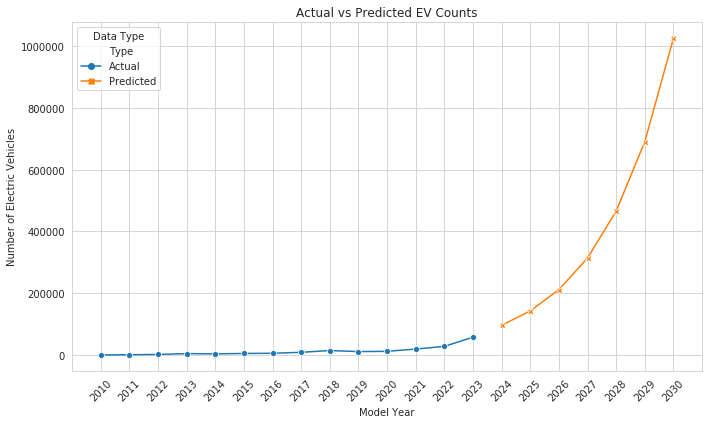

In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame
predicted_counts_pandas = predicted_counts.toPandas()

# Convert predicted counts to integer
predicted_counts_pandas['predicted_counts'] = predicted_counts_pandas['predicted_counts'].astype(int)

# Convert your predictions to a pandas DataFrame
predictions_df = pd.DataFrame({
    'Model Year': predicted_counts_pandas['Model Year'],
    'Number of Electric Vehicles': predicted_counts_pandas['predicted_counts'],
    'Type': 'Predicted'  # Mark these records as predictions
})

# Add actual data from your existing DataFrame to mark those records as actual
pandas_df['Type'] = 'Actual'

# Combine the actual and predicted data into one DataFrame
combined_df = pd.concat([pandas_df, predictions_df], ignore_index=True)

# Setting up the seaborn style for better aesthetics
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_df, x='Model Year', y='Number of Electric Vehicles', hue='Type', style='Type', markers=True, dashes=False)

# Adding plot title and labels
plt.title('Actual vs Predicted EV Counts')
plt.xlabel('Model Year')
plt.ylabel('Number of Electric Vehicles')

# Show the plot
plt.legend(title='Data Type')
plt.xticks(combined_df['Model Year'].unique(), rotation=45)  # Ensure all years are shown and rotate them for better readability
plt.tight_layout()  # Adjusts subplot params for the plot to fit into the figure area
plt.show()


In [ ]:
import pandas as pd
print(predicted_counts)
# Convert your predictions to a pandas DataFrame
predictions_df = pd.DataFrame({
    'Model Year': future_years.flatten(),
    'Number of Electric Vehicles': predicted_counts.astype(int),
    'Type': 'Predicted'  # Mark these records as predictions
})

# Add actual data from your existing DataFrame to mark those records as actual
pandas_df['Type'] = 'Actual'

# Combine the actual and predicted data into one DataFrame
combined_df = pd.concat([pandas_df, predictions_df], ignore_index=True)


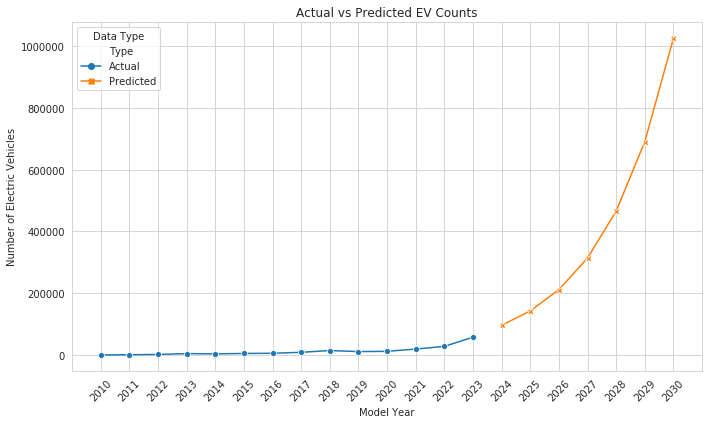

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the seaborn style for better aesthetics
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_df, x='Model Year', y='Number of Electric Vehicles', hue='Type', style='Type', markers=True, dashes=False)

# Adding plot title and labels
plt.title('Actual vs Predicted EV Counts')
plt.xlabel('Model Year')
plt.ylabel('Number of Electric Vehicles')

# Show the plot
plt.legend(title='Data Type')
plt.xticks(combined_df['Model Year'].unique(), rotation=45)  # Ensure all years are shown and rotate them for better readability
plt.tight_layout()  # Adjusts subplot params for the plot to fit into the figure area
plt.show()
